# BT4016 Final Project

## Import Libraries

In [48]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import math
from math import sqrt, exp
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
def get_data_for_multiple_stocks(tickers,start_date="2020-02-01",end_date="2022-02-01"):
    # initialise output dataframe
    returns_df = pd.DataFrame()
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers: 
        format="%Y-%m-%d"
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))

        # append to returns_df
        returns_df[ticker+'_adj_close'] = s['Adj Close']

        # Transform Date from integer to date type
    # returns_df = returns_df.reset_index() #to be able to access it as a pandas column rather than index
    # returns_df['Date'] = pd.to_datetime(returns_df['Date'], infer_datetime_format=True)
    
    # rename columns
    returns_df.rename(columns={"BTC-USD_adj_close": "BTC_close", \
                   "ETH-USD_adj_close": "ETH_close", \
                    "DOGE-USD_adj_close": "DOGE_close", \
                    "MATIC-USD_adj_close": "MATIC_close"}, inplace=True)
    
    returns_df['BTC_log_return'] = np.log(returns_df['BTC_close'] / returns_df['BTC_close'].shift(1))
    returns_df['ETH_log_return'] = np.log(returns_df['ETH_close'] / returns_df['ETH_close'].shift(1))
    returns_df['DOGE_log_return'] = np.log(returns_df['DOGE_close'] / returns_df['DOGE_close'].shift(1))
    returns_df['MATIC_log_return'] = np.log(returns_df['MATIC_close'] / returns_df['MATIC_close'].shift(1))

    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    returns_df = returns_df.iloc[1:].fillna(0)

    return returns_df

Since in practice, the risk-free rate is commonly considered to equal to the interest paid on a 3-month government Treasury Bills, generally the safest investment an investor can make, we decided to download the daily price of the US government Treasury Bills.

Refer from: [Risk free rate](https://corporatefinanceinstitute.com/resources/valuation/risk-free-rate/)

In [50]:
tickers = ["BTC-USD", "ETH-USD", "DOGE-USD", "MATIC-USD"]
start_date = "2020-02-01"
end_date = "2022-02-01"
np.random.seed(4016)
cmap = {"BTC": np.random.rand(3,),
        "ETH": np.random.rand(3,),
        "DOGE": np.random.rand(3,),
        "MATIC": np.random.rand(3,)}

df = get_data_for_multiple_stocks(tickers, start_date, end_date)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2020-02-02,9344.365234,188.617538,0.002468,0.019115,-0.005178,0.026559,0.018814,0.041880
2020-02-03,9293.521484,189.865067,0.002440,0.022086,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,9180.962891,189.250595,0.002503,0.021129,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,9613.423828,204.230240,0.002582,0.021433,0.046028,0.076176,0.031074,0.014285
2020-02-06,9729.801758,212.339081,0.002653,0.024459,0.012033,0.038936,0.027127,0.132067


## Question 1

Text(0.5, 1.0, 'Asset Correlations')

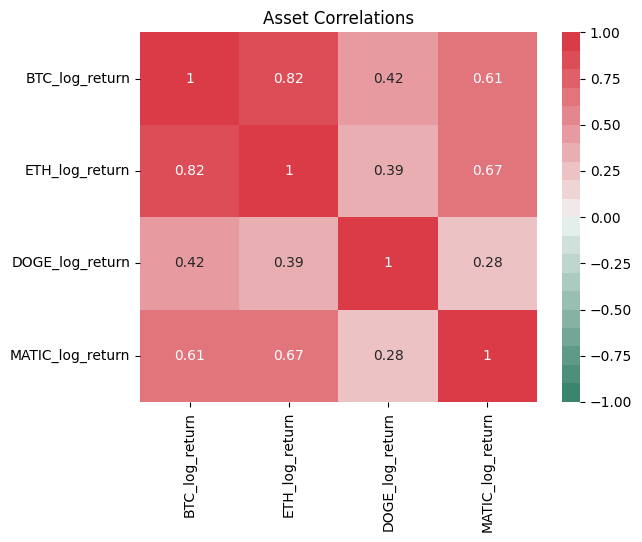

In [51]:
corr = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]].corr()
sns.heatmap(corr, cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

Here, we observe that `DOGE` has the weakest correlation with the other crypto assets. We want to select assets with low correlation to reap the benefits from diversification. If we use assets with very high correlation (e.g. 0.9), there will barely be any diversification benefits and we may run into issues in subsequent optimization.

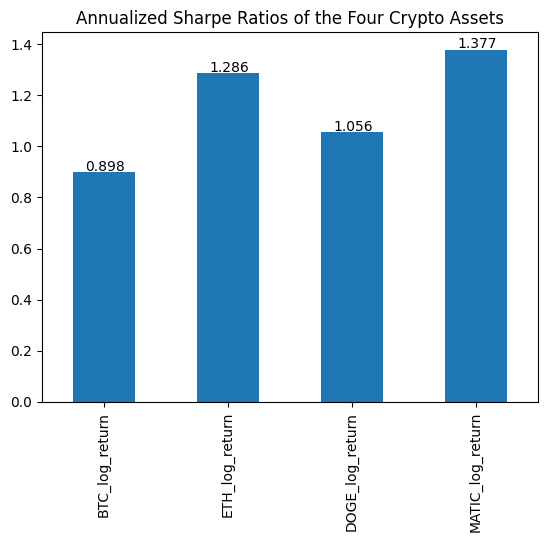

In [52]:
df_return = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
mean_daily_returns = df_return.mean()
std_daily_returns = df_return.std()

annualized_mean_returns = mean_daily_returns * 365
annualized_std_returns = std_daily_returns * np.sqrt(365)
sharpe_ratios = round((annualized_mean_returns) / annualized_std_returns, 3)

# Plot the bar chart
ax = sharpe_ratios.plot(kind='bar', title='Annualized Sharpe Ratios of the Four Crypto Assets')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/5, p.get_height() * 1.005))

All assets in the portfolio are positively correlated, heavily exposing the portfolio to a single factor or market condition. 

Looking at the bar chart, it is evident that `MATIC` has the highest Sharpe Ratio of 1.377 (rounded to 3 decimal places), followed by `ETH` which has a Sharpe Ratio of 1.286. `DOGE` has a Sharpe Ratio of 1.056, while `BTC` has the lowest Sharpe Ratio of 0.898.

The Sharpe ratio is a measure of risk-adjusted return, and a higher value implies that an investment is generating higher returns relative to the risk taken on. Therefore, the statement implies that `MATIC` has the highest risk-adjusted return among the four cryptocurrencies, followed by `ETH`, `DOGE`, and finally `BTC`.

## Question 2

In order to compute the varying weights for each stock in each day, we decided to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the weight of each asset for today.

In [53]:
import cvxpy as cvx

In [54]:
# shifted 1 year earlier than the problem's specified date
start_date = "2019-02-01"
end_date = "2022-02-02"

df2 = get_data_for_multiple_stocks(tickers, start_date, end_date)
df2.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2019-02-02,3521.060791,110.430260,0.001936,0.0,0.009449,0.025873,0.010384,0.0
2019-02-03,3464.013428,107.492668,0.001904,0.0,-0.016334,-0.026962,-0.016667,0.0
2019-02-04,3459.154053,107.821602,0.001896,0.0,-0.001404,0.003055,-0.004211,0.0
2019-02-05,3466.357422,107.443520,0.001888,0.0,0.002080,-0.003513,-0.004228,0.0
2019-02-06,3413.767822,104.919289,0.001866,0.0,-0.015288,-0.023774,-0.011721,0.0


In [55]:
df_return = df2[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
simple_returns = np.exp(df_return) -1
simple_returns.rename(columns={"BTC_log_return": "BTC_return", \
                   "ETH_log_return": "ETH_return", \
                    "DOGE_log_return": "DOGE_return", \
                    "MATIC_log_return": "MATIC_return"}, inplace=True)
simple_returns

,BTC_return,ETH_return,DOGE_return,MATIC_return
Date,,,,
2019-02-02,0.009494,0.026210,0.010438,0.000000
2019-02-03,-0.016202,-0.026601,-0.016529,0.000000
2019-02-04,-0.001403,0.003060,-0.004202,0.000000
2019-02-05,0.002082,-0.003507,-0.004219,0.000000
2019-02-06,-0.015171,-0.023494,-0.011653,0.000000
...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995
2022-01-29,0.009365,0.019627,0.009883,0.009378
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883


### Standard Optimization using `cvxpy`

We will set the following constraints:
1. Long Only
2. Sum of weights = 1 (Leverage of 1)
3. Risk management, single stock allocation has to be less than or equal to 50%

In [56]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    
    log_returns_df = np.log(returns_df+1)
    
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return

    total_simple_return = np.exp(total_return_log) -1
    # print(total_simple_return)
    frequency = 365 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
    # print("geometric return")
    # print(expected_mean)
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))

    ## Important here: --------------------------------------------------------------------------------
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)

    ## Important ends -----------------------------------------------------------------------------------
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()

    return x.value

def compute_log_portfolio_returns(returns, weights_df):

    weighted_returns = pd.DataFrame(returns.values * weights_df.values, columns=returns.columns, index=returns.index)
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns + 1)
    
    return log_returns

### Portfolio 1: Only Minimize Risk, Limit Maximum Holdings to 0.5

In [57]:
weights_df = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=0.5)
        weights_df.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df.loc[date] = np.NaN

In [58]:
weights_df.dropna(inplace=True)
weights_lim_holdings_df = deepcopy(weights_df)
weights_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4643,-0.0000,0.5000,0.0357
2020-02-03,0.4644,-0.0000,0.5000,0.0356
2020-02-04,0.4642,-0.0000,0.5000,0.0358
2020-02-05,0.4641,-0.0000,0.5000,0.0359
2020-02-06,0.4637,-0.0000,0.5000,0.0363
...,...,...,...,...
2022-01-28,0.5000,0.5000,0.0000,0.0000
2022-01-29,0.5000,0.4651,0.0349,-0.0000
2022-01-30,0.5000,0.4613,0.0387,-0.0000
2022-01-31,0.5000,0.4590,0.0410,-0.0000


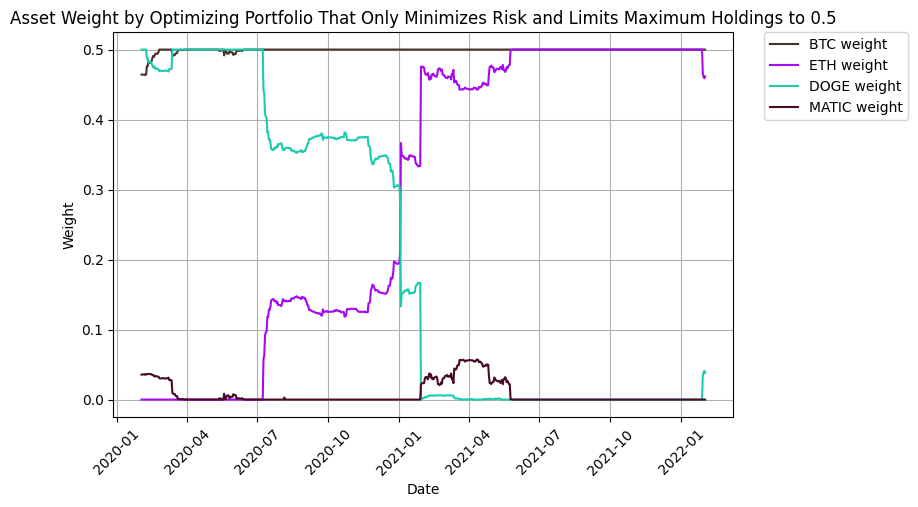

In [59]:
plt.figure(figsize=(8,5))
for col in weights_lim_holdings_df.columns:
    plt.plot(weights_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk and Limits Maximum Holdings to 0.5')
plt.show()

### Portfolio 2: Only Minimize Risk, Do Not Limit Maximum Holdings

In [60]:
weights_df2 = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=1)
        weights_df2.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df2.loc[date] = np.NaN   

In [61]:
weights_df2.dropna(inplace=True)
weights_no_lim_holdings_df = deepcopy(weights_df2)
weights_no_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4498,0.0,0.5148,0.0353
2020-02-03,0.4503,0.0,0.5145,0.0352
2020-02-04,0.4503,0.0,0.5143,0.0354
2020-02-05,0.4506,0.0,0.5139,0.0355
2020-02-06,0.4490,0.0,0.5151,0.0359
...,...,...,...,...
2022-01-28,1.0000,0.0,-0.0000,0.0000
2022-01-29,0.9929,-0.0,0.0071,-0.0000
2022-01-30,0.9904,-0.0,0.0096,-0.0000
2022-01-31,0.9897,-0.0,0.0103,-0.0000


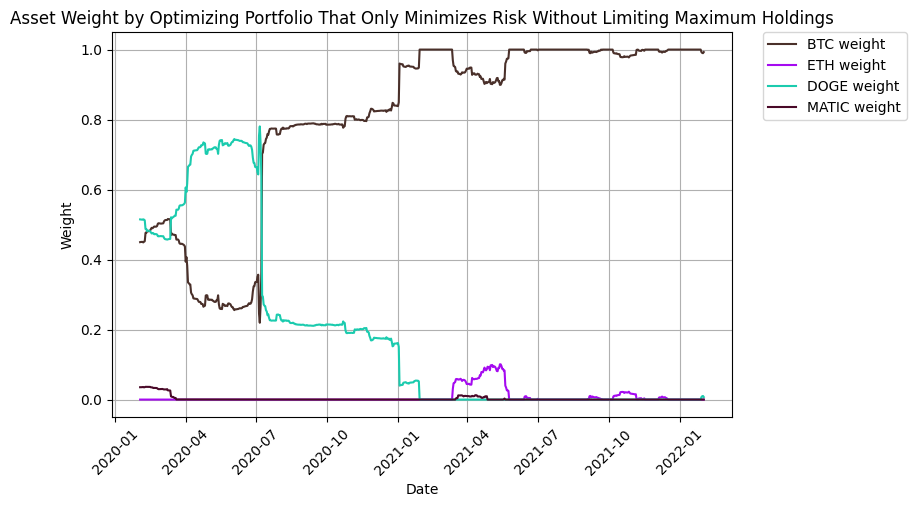

In [62]:
plt.figure(figsize=(8,5))
for col in weights_no_lim_holdings_df.columns:
    plt.plot(weights_no_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk Without Limiting Maximum Holdings')
plt.show()

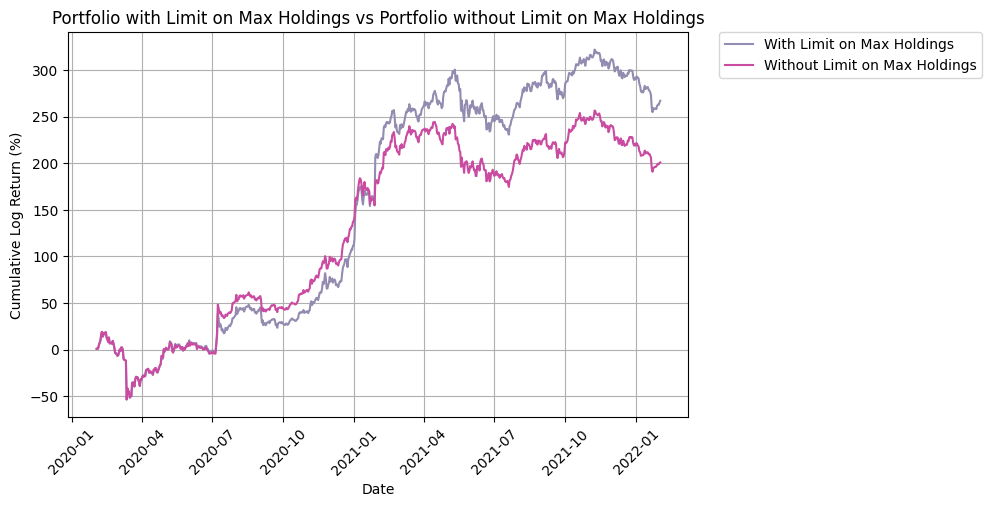

In [63]:
portfolio1 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_lim_holdings_df)
portfolio2 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_no_lim_holdings_df)
all_portfolio_returns = pd.concat([portfolio1, portfolio2], axis = 1)
all_portfolio_returns.columns = ["With Limit on Max Holdings", "Without Limit on Max Holdings"]

plt.figure(figsize=(8,5))
for col in all_portfolio_returns.columns:
    rgb = np.random.rand(3,)
    plt.plot(all_portfolio_returns[col].expanding(0).apply(lambda x: sum(x) * 100, raw = True), c=rgb, label=(col))

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Portfolio with Limit on Max Holdings vs Portfolio without Limit on Max Holdings')
plt.show()

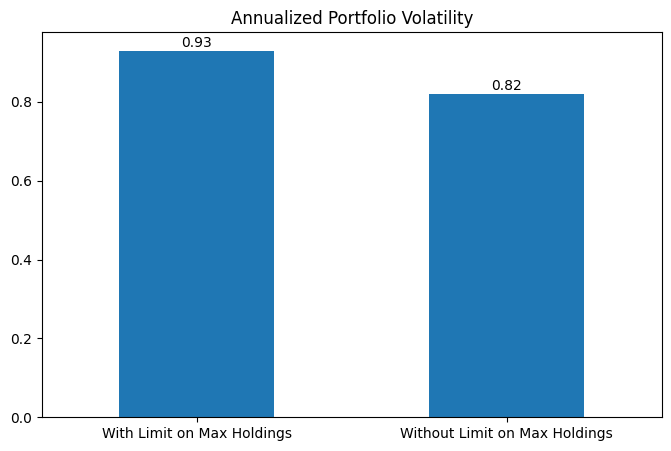

In [64]:
# plot volatility
ax = round(all_portfolio_returns.std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (8, 5))
plt.title("Annualized Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.20, p.get_height() + 0.01))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()

The portfolio with a limit on max holdings is able to obtain a higher cumulative return but at the cost of a higher volatility. 

## Question 3

Similarly, in order to compute the VaR and ES curve, we have to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the VaR and ES for today.

We use Historical Simulation method to estimate VaR and ES.

In [65]:
all_simple_return_df = deepcopy(simple_returns)
all_simple_return_df["Portfolio2_return"] = np.exp(portfolio2) - 1
all_simple_return_df.dropna(inplace=True)
all_simple_return_df

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return
Date,,,,,
2020-02-02,-0.005165,0.026915,0.018993,0.042769,0.008964
2020-02-03,-0.005441,0.006614,-0.011345,0.155428,-0.002816
2020-02-04,-0.012112,-0.003236,0.025820,-0.043331,0.006291
2020-02-05,0.047104,0.079152,0.031562,0.014388,0.037956
2020-02-06,0.012106,0.039704,0.027498,0.141184,0.024668
...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969


In [66]:
all_simple_return_df.iloc[:, 2].name

'DOGE_return'

In [67]:
df_VaR_HS = deepcopy(all_simple_return_df)

for i in range(0, len(df_VaR_HS)):
    for j in range(len(all_simple_return_df.columns)):
        past_365 = df_VaR_HS.iloc[(i-365):(i), j]
        past_365.dropna(inplace=True)
        if len(past_365) == 365:
            VaR = past_365.quantile(0.05) # VaR of 95%
            log_returns_sorted = sorted(past_365.dropna())
            length = len(log_returns_sorted)

            cutoff_rt_index = math.floor(length*0.05 +1) - 1
                
            sum_rt = sum(log_returns_sorted[:cutoff_rt_index])

            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = VaR
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = sum_rt/len(log_returns_sorted[:cutoff_rt_index])
        else:
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = np.NaN
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = np.NaN


In [68]:
df_VaR_HS.dropna(inplace=True)
df_old_HS = deepcopy(df_VaR_HS)
df_VaR_HS = df_VaR_HS.loc["2020-02-01":]
df_VaR_HS

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return,BTC_return_VaR_95,BTC_return_ES_95,ETH_return_VaR_95,ETH_return_ES_95,DOGE_return_VaR_95,DOGE_return_ES_95,MATIC_return_VaR_95,MATIC_return_ES_95,Portfolio2_return_VaR_95,Portfolio2_return_ES_95
Date,,,,,,,,,,,,,,,
2021-02-01,0.012768,0.041106,-0.062399,0.067870,0.012768,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-02,0.058834,0.106756,-0.096201,0.005040,0.058834,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-03,0.055246,0.096170,0.177665,0.067011,0.055246,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-04,-0.014571,-0.039826,0.435587,0.080094,-0.014571,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-05,0.032991,0.077684,-0.119237,0.156715,0.032991,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000


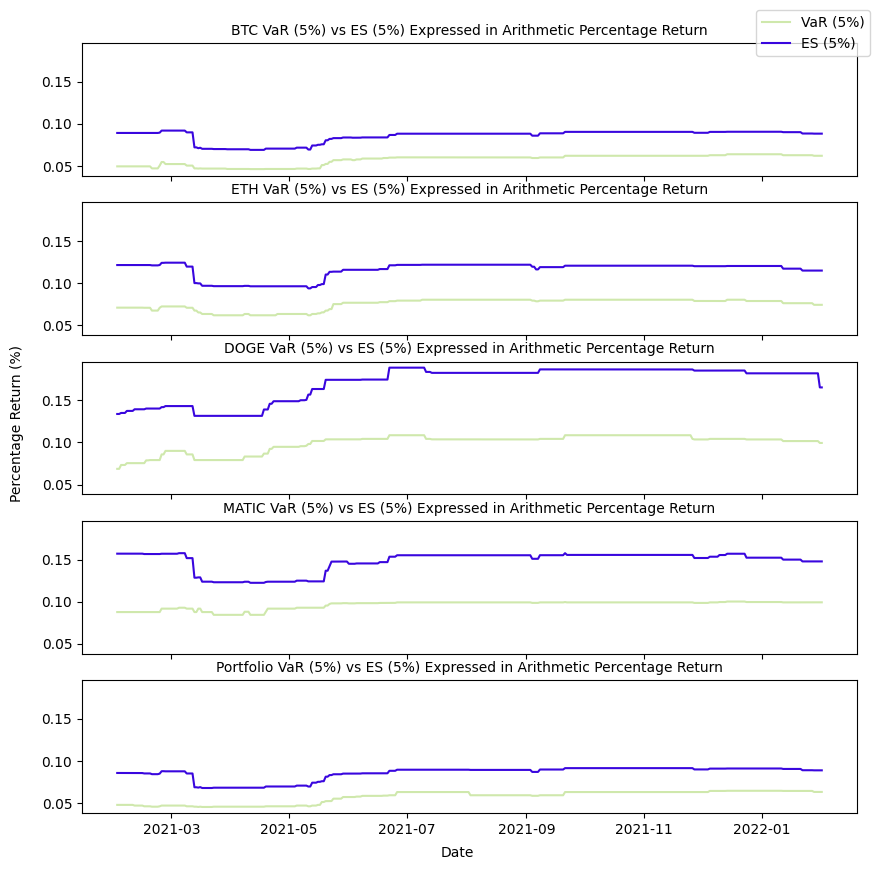

In [69]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True, sharey=True)
ax1, ax2, ax3, ax4, ax5 = axes.flatten()
var_col = np.random.rand(3,)
es_col = np.random.rand(3,)

var1, = ax1.plot(-df_VaR_HS['BTC_return_VaR_95'], c=var_col)
es1, = ax1.plot(-df_VaR_HS['BTC_return_ES_95'], c=es_col)
ax1.set_title('BTC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax1.title.set_size(10)

var2, = ax2.plot(-df_VaR_HS['ETH_return_VaR_95'], c=var_col)
es2, = ax2.plot(-df_VaR_HS['ETH_return_ES_95'], c=es_col)
ax2.set_title('ETH VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax2.title.set_size(10)

var3, = ax3.plot(-df_VaR_HS['DOGE_return_VaR_95'], c=var_col)
es3, = ax3.plot(-df_VaR_HS['DOGE_return_ES_95'], c=es_col)
ax3.set_title('DOGE VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax3.title.set_size(10)

var4, = ax4.plot(-df_VaR_HS['MATIC_return_VaR_95'], c=var_col)
es4, = ax4.plot(-df_VaR_HS['MATIC_return_ES_95'], c=es_col)
ax4.set_title('MATIC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax4.title.set_size(10)

var5, = ax5.plot(-df_VaR_HS['Portfolio2_return_VaR_95'], c=var_col)
es5, = ax5.plot(-df_VaR_HS['Portfolio2_return_ES_95'], c=es_col)
ax5.set_title('Portfolio VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax5.title.set_size(10)

fig.legend((var5, es5), ('VaR (5%)', 'ES (5%)'), loc='upper right', bbox_to_anchor=[0.92, 0.92])

# Set common labels
fig.text(0.5, 0.07, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Percentage Return (%)', ha='center', va='center', rotation='vertical')

plt.show()


DOGE is the riskiest component in the portfolio as it has the highest VaR and ES value among all 4 assets. 

## Question 4

In [70]:
options_df = df2['2020-02-01':][['BTC_close','ETH_close']].copy()
options_df['BTC_daily_returns'] = options_df['BTC_close'].pct_change()
options_df['ETH_daily_returns'] = options_df['ETH_close'].pct_change()
btc_pos_std_dev = np.std(options_df.loc[options_df['BTC_daily_returns'] > 0]['BTC_daily_returns'])
btc_neg_std_dev = np.std(options_df.loc[options_df['BTC_daily_returns'] < 0]['BTC_daily_returns'])
eth_pos_std_dev = np.std(options_df.loc[options_df['ETH_daily_returns'] > 0]['ETH_daily_returns'])
eth_neg_std_dev = np.std(options_df.loc[options_df['ETH_daily_returns'] < 0]['ETH_daily_returns'])
print(f'Bitcoin - Standard deviation of positive returns: {btc_pos_std_dev*100:.3f}%')
print(f'Bitcoin - Standard deviation of negative returns: {btc_neg_std_dev*100:.3f}%')
print(f'Ethereum - Standard deviation of positive returns: {eth_pos_std_dev*100:.3f}%')
print(f'Ethereum - Standard deviation of negative returns: {eth_neg_std_dev*100:.3f}%')

Bitcoin - Standard deviation of positive returns: 2.790%
Bitcoin - Standard deviation of negative returns: 3.122%
Ethereum - Standard deviation of positive returns: 3.587%
Ethereum - Standard deviation of negative returns: 4.029%


In [71]:
# Upside Potential Ratio
risk_free_rate = 0.02
btc_returns = options_df['BTC_daily_returns']
btc_positive_returns = options_df.loc[options_df['BTC_daily_returns'] > 0]['BTC_daily_returns']
btc_negative_returns = options_df.loc[options_df['BTC_daily_returns'] < 0]['BTC_daily_returns']
btc_upr = np.mean(btc_positive_returns)/np.abs(np.mean(btc_negative_returns))
print("BTC's Upside Potential Ratio is ", btc_upr)
btc_returns_lower_than_risk_free_rate = options_df.loc[options_df['BTC_daily_returns'] < risk_free_rate]['BTC_daily_returns']
btc_dr = np.sqrt(np.mean(np.square(btc_returns_lower_than_risk_free_rate)))
print("BTC's Downside Risk is ", btc_dr)
# Sortino Ratio and risk return trade-off
# btc_expected_return = np.mean(btc_returns)
# btc_downside_deviation = np.std(btc_returns_lower_than_risk_free_rate)
# btc_sortino_ratio = (btc_expected_return - risk_free_rate) / btc_downside_deviation
# print(btc_sortino_ratio)
# btc_risk_return_trade_off = btc_expected_return/btc_downside_deviation
# print(btc_risk_return_trade_off)

eth_returns = options_df['ETH_daily_returns']
eth_positive_returns = options_df.loc[options_df['ETH_daily_returns'] > 0]['ETH_daily_returns']
eth_negative_returns = options_df.loc[options_df['ETH_daily_returns'] < 0]['ETH_daily_returns']
eth_upr = np.mean(eth_positive_returns)/np.abs(np.mean(eth_negative_returns))
print("ETH's Upisde Potential Ratio is ", eth_upr)
eth_returns_lower_than_risk_free_rate = options_df.loc[options_df['ETH_daily_returns'] < risk_free_rate]['ETH_daily_returns']
eth_dr = np.sqrt(np.mean(np.square(eth_returns_lower_than_risk_free_rate)))
print("ETH's Downside Risk is ", eth_dr)
# Sortino Ratio and risk return trade-off
# eth_expected_return = np.mean(eth_returns)
# eth_downside_deviation = np.std(eth_returns_lower_than_risk_free_rate)
# eth_sortino_ratio = (eth_expected_return - risk_free_rate) / eth_downside_deviation
# print(eth_sortino_ratio)
# eth_risk_return_trade_off = eth_expected_return/eth_downside_deviation
# print(eth_risk_return_trade_off)

BTC's Upside Potential Ratio is  1.0677228961544065
BTC's Downside Risk is  0.03286138746928183
ETH's Upisde Potential Ratio is  1.0525071575334253
ETH's Downside Risk is  0.045050570678937495


An Upside potential ratio (UPR) is the ratio of potential gain vs potential loss. A UPR of 1 means that potential gain and potential loss are equal, while a UPR greater than 1 means that potential gain is higher than potential loss. 

Downside Risk (DR) indicates the likelihood of returns falling below the risk-free rate.

ETH has a lower upside potential ratio and a higher downside risk and thus, ETH's prices are more volatile. 

Ethereum appears to be more volatile than Bitcoin, with a larger daily downside risk of 4.03% compared to Bitcoin's 3.12% and also a larger daily upside volatility of 3.59% compared to Bitcoin's 2.79%.

In [72]:
ethpriceatbuying = float(options_df.loc['2021-01-01']['ETH_close'])
ethpriceatbuying = round(ethpriceatbuying, 2)
ethcallprice = ethpriceatbuying*(1+eth_pos_std_dev)
ethcallprice = round(ethcallprice, 2)
ethputprice = ethpriceatbuying*(1-eth_neg_std_dev)
ethputprice = round(ethputprice, 2)
print(f'Price of ETH on 2021-01-01: {ethpriceatbuying}USD')
print(f'Maximum strike price to buy: {ethcallprice}USD')
print(f'Minimum strike price to buy: {ethputprice}USD')

Price of ETH on 2021-01-01: 730.37USD
Maximum strike price to buy: 756.57USD
Minimum strike price to buy: 700.94USD


In [73]:
options = pd.read_csv('OKEx_options_trade.csv')
options.drop(options.index[0], inplace=True)
options = options.drop(columns=['Unnamed: 0'])
options = options[pd.to_numeric(options['qty'], errors='coerce').notnull()]
options['exercise_date'] = options['instrument_id'].str.extract(r'(\d{6})')
options['exercise_date'] = pd.to_datetime(options['exercise_date'], format='%y%m%d')
options['strike_price'] = options['instrument_id'].str.extract(r'-(\d+)-[A-Z]')
options['coin_type'] = options['instrument_id'].str.split('-', n=1).str[0]
options['option_type'] = options['instrument_id'].str[-1]
options = options.sort_values(by='exercise_date')

In [74]:
options

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type
128,sell,68,0.01,4,BTC-USD-200207-10000-C,2020-02-01T07:04:52.544Z,2020-02-07,10000,BTC,C
150,buy,59,0.024,20,BTC-USD-200207-9500-C,2020-02-01T08:31:30.077Z,2020-02-07,9500,BTC,C
151,buy,60,0.024,100,BTC-USD-200207-9500-C,2020-02-01T08:31:38.836Z,2020-02-07,9500,BTC,C
152,buy,61,0.024,100,BTC-USD-200207-9500-C,2020-02-01T08:31:43.632Z,2020-02-07,9500,BTC,C
153,buy,62,0.024,85,BTC-USD-200207-9500-C,2020-02-01T08:31:47.593Z,2020-02-07,9500,BTC,C
...,...,...,...,...,...,...,...,...,...,...
99842,sell,4,0.031,1,BTC-USD-220325-34000-P,2021-11-22T03:42:30.941Z,2022-03-25,34000,BTC,P
99843,sell,19,0.282,14,BTC-USD-220325-50000-C,2021-11-19T08:40:20.263Z,2022-03-25,50000,BTC,C
99844,buy,10,0.103,1,BTC-USD-220325-46000-P,2021-11-22T21:12:47.081Z,2022-03-25,46000,BTC,P
99919,buy,13,0.0045,2,ETH-USD-220325-1200-P,2021-11-30T15:29:55.196Z,2022-03-25,1200,ETH,P


In [75]:
putstobuy = options.loc[(options['exercise_date']=='2021-01-08') & (options['coin_type']=='ETH') & (options['option_type']=='P')]
putstobuy

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type
74445,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P
74444,sell,5,0.039,1,ETH-USD-210108-700-P,2020-12-31T14:35:01.590Z,2021-01-08,700,ETH,P
74443,buy,27,0.019,8,ETH-USD-210108-660-P,2020-12-31T13:00:27.212Z,2021-01-08,660,ETH,P
74442,buy,24,0.0075,2,ETH-USD-210108-630-P,2020-12-30T22:43:48.256Z,2021-01-08,630,ETH,P
74441,sell,21,0.005,7,ETH-USD-210108-600-P,2020-12-31T15:03:00.346Z,2021-01-08,600,ETH,P
...,...,...,...,...,...,...,...,...,...,...
73119,buy,9,0.0265,1,ETH-USD-210108-680-P,2020-12-30T07:46:48.149Z,2021-01-08,680,ETH,P
73118,sell,18,0.0145,2,ETH-USD-210108-650-P,2020-12-31T15:02:48.168Z,2021-01-08,650,ETH,P
73117,buy,23,0.0065,159,ETH-USD-210108-620-P,2020-12-31T02:41:56.912Z,2021-01-08,620,ETH,P
73116,buy,3,0.0035,1,ETH-USD-210108-560-P,2020-12-31T17:02:53.357Z,2021-01-08,560,ETH,P


In [76]:
callstobuy = options.loc[(options['exercise_date']=='2021-01-08') & (options['coin_type']=='ETH') & (options['option_type']=='C')]
callstobuy

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type
73671,sell,35,0.0575,10,ETH-USD-210108-740-C,2020-12-31T21:34:22.471Z,2021-01-08,740,ETH,C
74400,buy,9,0.0035,5,ETH-USD-210108-1000-C,2021-01-01T01:12:52.687Z,2021-01-08,1000,ETH,C
74399,buy,4,0.016,70,ETH-USD-210108-900-C,2020-12-30T00:02:36.502Z,2021-01-08,900,ETH,C
78138,sell,1,0.0165,6,ETH-USD-210108-860-C,2020-12-30T10:16:37.661Z,2021-01-08,860,ETH,C
78139,sell,4,0.0045,500,ETH-USD-210108-920-C,2021-01-01T16:07:14.767Z,2021-01-08,920,ETH,C
...,...,...,...,...,...,...,...,...,...,...
73038,sell,2,0.0095,298,ETH-USD-210108-920-C,2020-12-30T11:41:46.471Z,2021-01-08,920,ETH,C
73037,sell,1,0.0165,6,ETH-USD-210108-860-C,2020-12-30T10:16:37.661Z,2021-01-08,860,ETH,C
73034,buy,12,0.042,1,ETH-USD-210108-780-C,2020-12-31T07:05:29.320Z,2021-01-08,780,ETH,C
73035,sell,49,0.029,12,ETH-USD-210108-800-C,2020-12-31T22:16:35.909Z,2021-01-08,800,ETH,C


In [77]:
# strikeprice = ethcallprice + 0.5*eth_pos_std_dev
# diff = strikeprice - callstobuy['strike_price'].astype(int)
# min_diff_index = diff.abs().idxmin()
# min_diff = diff[min_diff_index]
# callcandidates = callstobuy.loc[(strikeprice - callstobuy['strike_price'].astype(int) == min_diff)]
# callcandidates = callcandidates.sort_values('price', ascending=True)
# callcandidates

In [78]:
strikeprice = ethcallprice + 0.5*eth_pos_std_dev
diff = strikeprice - callstobuy['strike_price'].astype(int)
callcandidates = deepcopy(callstobuy)
callcandidates['abs_diff'] = diff.abs()
callcandidates = callcandidates.sort_values('abs_diff', ascending=True)
callcandidates[callcandidates['side'] == 'sell'].head(10)

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type,abs_diff
78285,sell,17,0.035,1,ETH-USD-210108-760-C,2021-01-01T17:16:43.855Z,2021-01-08,760,ETH,C,3.412066
77767,sell,17,0.035,1,ETH-USD-210108-760-C,2021-01-01T17:16:43.855Z,2021-01-08,760,ETH,C,3.412066
73905,sell,36,0.0585,5,ETH-USD-210108-740-C,2021-01-01T01:36:23.707Z,2021-01-08,740,ETH,C,16.587934
78326,sell,43,0.0375,2,ETH-USD-210108-740-C,2021-01-01T19:05:19.309Z,2021-01-08,740,ETH,C,16.587934
78136,sell,41,0.039,20,ETH-USD-210108-740-C,2021-01-01T18:56:49.072Z,2021-01-08,740,ETH,C,16.587934
73906,sell,37,0.059,5,ETH-USD-210108-740-C,2021-01-01T01:36:38.036Z,2021-01-08,740,ETH,C,16.587934
73671,sell,35,0.0575,10,ETH-USD-210108-740-C,2020-12-31T21:34:22.471Z,2021-01-08,740,ETH,C,16.587934
73090,sell,35,0.0575,10,ETH-USD-210108-740-C,2020-12-31T21:34:22.471Z,2021-01-08,740,ETH,C,16.587934
78325,sell,42,0.0385,15,ETH-USD-210108-740-C,2021-01-01T19:02:16.621Z,2021-01-08,740,ETH,C,16.587934
77826,sell,40,0.038,20,ETH-USD-210108-740-C,2021-01-01T18:56:27.892Z,2021-01-08,740,ETH,C,16.587934


In [79]:
# putdiff = strikeprice - putstobuy['strike_price'].astype(int)
# put_min_diff_index = putdiff.abs().idxmin()
# put_min_diff = putdiff[put_min_diff_index]
# putcandidates = putstobuy.loc[(strikeprice - putstobuy['strike_price'].astype(int) == put_min_diff)]
# putcandidates = putcandidates.sort_values('price', ascending=True)
# putcandidates

In [80]:
diff = strikeprice - putstobuy['strike_price'].astype(int)
putcandidates = deepcopy(putstobuy)
putcandidates['abs_diff'] = diff.abs()
putcandidates = putcandidates.sort_values('abs_diff', ascending=True)
putcandidates[putcandidates['side'] == 'sell'].head(10)

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type,abs_diff
74445,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
75664,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
73801,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
73201,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
75122,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
76792,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
76271,sell,3,0.074,20,ETH-USD-210108-760-P,2020-12-31T03:14:30.338Z,2021-01-08,760,ETH,P,3.412066
74363,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,16.587934
73120,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,16.587934
73720,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,16.587934


In [81]:
print(f'Price of ETH on 2021-01-01: {ethpriceatbuying}USD')
ethpriceatexercise = float(options_df.loc['2021-01-08']['ETH_close'])
print(f'Price of ETH on 2021-01-08: {ethpriceatexercise}USD')
print(f'Total value of only holding one unit of ETH on 2021-01-08: {ethpriceatexercise}USD')
print(f'Percentage return of only holding one unit of ETH from 2021-01-01 to 2021-01-08: {ethpriceatexercise/ethpriceatbuying*100:.2f}%')

calloption_price = float(callcandidates[callcandidates['side'] == 'sell'].head(1)['price'].values[0])
putoption_price = float(putcandidates[putcandidates['side'] == 'sell'].head(1)['price'].values[0])
option_strikeprice = int(callcandidates[callcandidates['side'] == 'sell'].head(1)['strike_price'].values[0])
straddle_return = ethpriceatexercise * (1 - calloption_price - putoption_price) + max(ethpriceatexercise - option_strikeprice, 0) + max(option_strikeprice - ethpriceatexercise, 0)
print()
print(f'Price of ETH\'s call option and put option on 2021-01-01: {calloption_price}, {putoption_price} ETH')
print(f'Total value after exercising both put and call options of ETH on 2021-01-08: {straddle_return}USD')
print(f'Percentage return of using straddle strategy on ETH from 2021-01-01 to 2021-01-08: {straddle_return/ethpriceatbuying*100:.2f}%')

Price of ETH on 2021-01-01: 730.37USD
Price of ETH on 2021-01-08: 1224.1971435546875USD
Total value of only holding one unit of ETH on 2021-01-08: 1224.1971435546875USD
Percentage return of only holding one unit of ETH from 2021-01-01 to 2021-01-08: 167.61%

Price of ETH's call option and put option on 2021-01-01: 0.035, 0.074 ETH
Total value after exercising both put and call options of ETH on 2021-01-08: 1554.956798461914USD
Percentage return of using straddle strategy on ETH from 2021-01-01 to 2021-01-08: 212.90%


Assuming we have 1 unit of ETH on 2021-01-01, the percentage return of only holding one unit of ETH from 2021-01-01 to 2021-01-08 is **167.61%** (*2 d.p.*).  
However, if we applied straddle strategy, the percentage return of using straddle strategy on ETH from 2021-01-01 to 2021-01-08 can be up to **212.90%** (*2 d.p.*).

In [153]:
# ETH_df = df2.loc["2020-02-02":][["ETH_close", "ETH_log_return"]]
# ETH_df["ETH_return"] = ETH_df["ETH_log_return"].apply(lambda x: np.exp(x) -1)
# ETH_df
ETH_df = df2.loc["2020-02-01":][["ETH_close"]]
ETH_df = deepcopy(ETH_df)
ETH_df

,ETH_close
Date,
2020-02-01,183.673950
2020-02-02,188.617538
2020-02-03,189.865067
2020-02-04,189.250595
2020-02-05,204.230240
...,...
2022-01-28,2547.092041
2022-01-29,2597.084717
2022-01-30,2603.466553


Since on *2020-02-01*, we use 0.035 and 0.074 unit of ETH to buy a call option and a put option respectively, hence we subtract the premium of a total of 0.035 + 0.074 = 0.109 unit of ETH paid for the straddle from the closing price. This adjusted price becomes the new starting price for the daily return calculations.

In [154]:
ETH_df.loc["2021-01-01", "ETH_close"] = (1 - 0.035 - 0.074) * ETH_df.loc["2021-01-01", "ETH_close"]
ETH_df.loc["2021-01-08", "ETH_close"] = ETH_df.loc["2021-01-08", "ETH_close"] + max(ethpriceatexercise - option_strikeprice, 0) + max(option_strikeprice - ethpriceatexercise, 0)
ETH_df['ETH_original_close'] = df2.loc["2020-02-01":][["ETH_close"]]
ETH_df['original_log_return'] = np.log(ETH_df['ETH_original_close'] / ETH_df['ETH_original_close'].shift(1))
ETH_df['log_return'] = np.log(ETH_df['ETH_close'] / ETH_df['ETH_close'].shift(1))
ETH_df.dropna(inplace=True)
ETH_df

,ETH_close,ETH_original_close,original_log_return,log_return
Date,,,,
2020-02-02,188.617538,188.617538,0.026559,0.026559
2020-02-03,189.865067,189.865067,0.006592,0.006592
2020-02-04,189.250595,189.250595,-0.003242,-0.003242
2020-02-05,204.230240,204.230240,0.076176,0.076176
2020-02-06,212.339081,212.339081,0.038936,0.038936
...,...,...,...,...
2022-01-28,2547.092041,2547.092041,0.049945,0.049945
2022-01-29,2597.084717,2597.084717,0.019437,0.019437
2022-01-30,2603.466553,2603.466553,0.002454,0.002454


In [155]:
ETH_df_return = deepcopy(ETH_df[["original_log_return", "log_return"]])
ETH_df_return['original_return'] = np.exp(ETH_df_return['original_log_return']) - 1
ETH_df_return['return'] = np.exp(ETH_df_return['log_return']) - 1

ETH_weighted_return = pd.DataFrame(index=ETH_df.index)
ETH_weighted_return['original_return'] = ETH_df_return['original_return'] * weights_no_lim_holdings_df['ETH']
ETH_weighted_return['return'] = ETH_df_return['return'] * weights_no_lim_holdings_df['ETH']

ETH_weighted_log_returns = np.log(ETH_weighted_return + 1)
ETH_weighted_log_returns.columns = ["Without Using Straddle", "Using Straddle"]

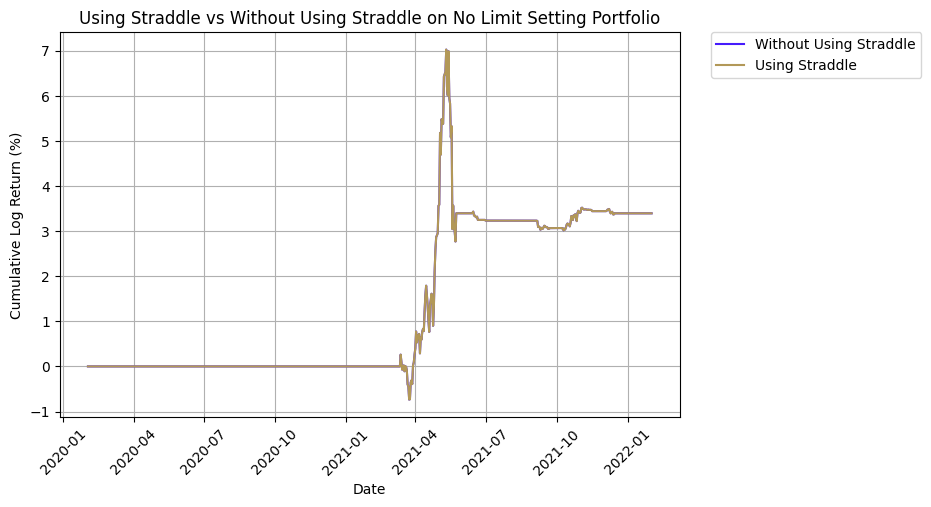

In [156]:
plt.figure(figsize=(8,5))
for col in ETH_weighted_log_returns.columns:
    rgb = np.random.rand(3,)
    plt.plot(ETH_weighted_log_returns[col].expanding(0).apply(lambda x: sum(x) * 100, raw = True), c=rgb, label=(col))

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Using Straddle vs Without Using Straddle on No Limit Setting Portfolio')
plt.show()

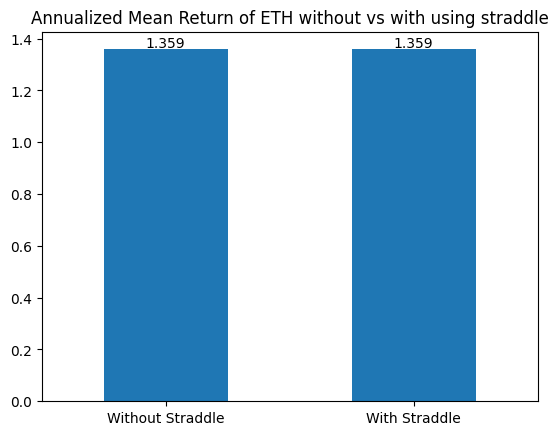

In [162]:
mean_ETH_returns = ETH_df_return[["original_log_return", "log_return"]].mean()
std_ETH_returns = ETH_df_return[["original_log_return", "log_return"]].std()

annualized_ETH_mean_returns = mean_ETH_returns * 365
annualized_ETH_mean_returns.index = ["Without Straddle", "With Straddle"]

# Plot the bar chart
ax = annualized_ETH_mean_returns.plot(kind='bar', title='Annualized Mean Return of ETH without vs with using straddle')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width()/3, p.get_height() * 1.005))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()

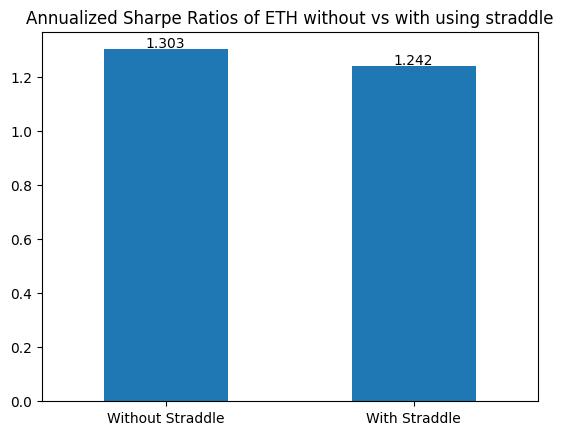

In [164]:
annualized_ETH_std_returns = std_ETH_returns * np.sqrt(365)
annualized_ETH_std_returns.index = ["Without Straddle", "With Straddle"]
sharpe_ratios = round((annualized_ETH_mean_returns) / annualized_ETH_std_returns, 3)

# Plot the bar chart
ax = sharpe_ratios.plot(kind='bar', title='Annualized Sharpe Ratios of ETH without vs with using straddle')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/3, p.get_height() * 1.005))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()